## Merge 2 dataset

In [1]:
import os
import glob

## Đọc dataset Student-Behavior

## SCB

## Visualize số ảnh số lớp

### Bouding box

## Student

Visualize samples từ tập train:


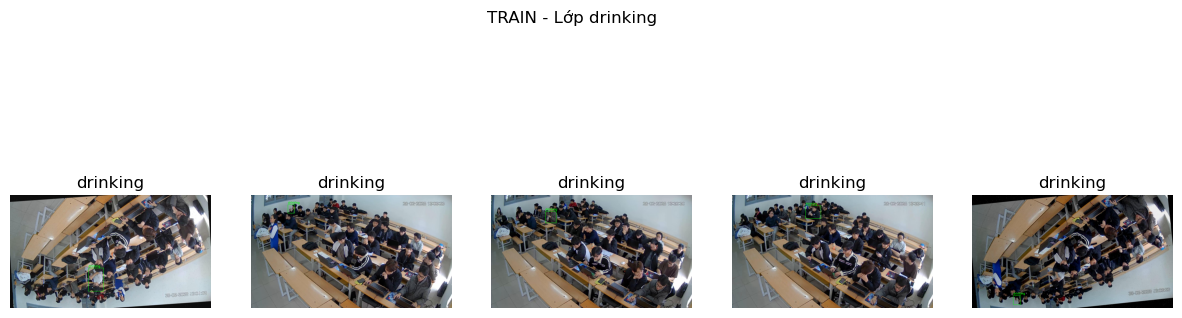

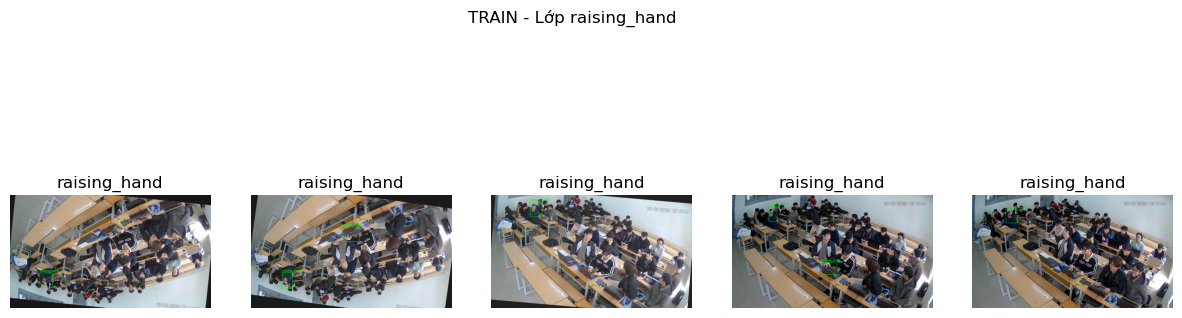

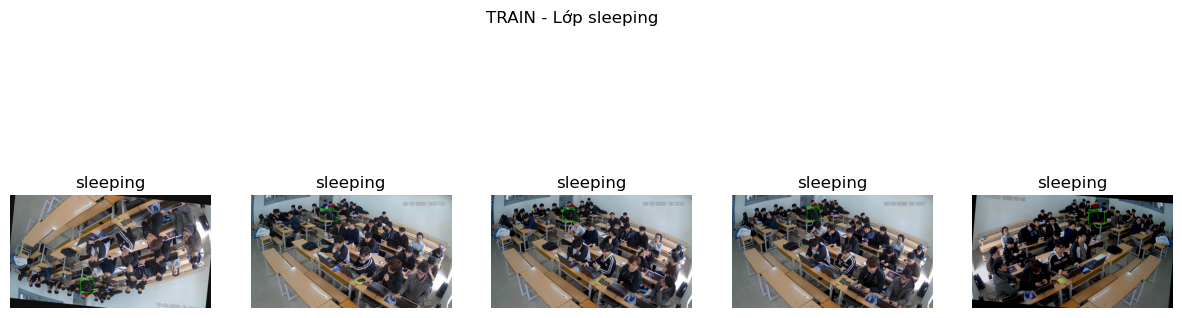

Không có ảnh cho lớp using_computer
Không có ảnh cho lớp using_phone
Không có ảnh cho lớp writing
Visualize samples từ tập val:


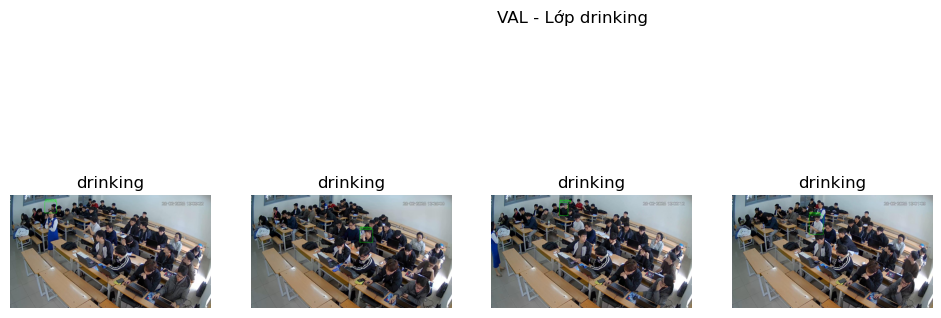

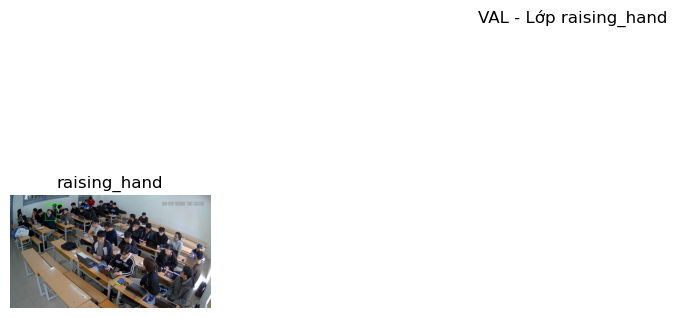

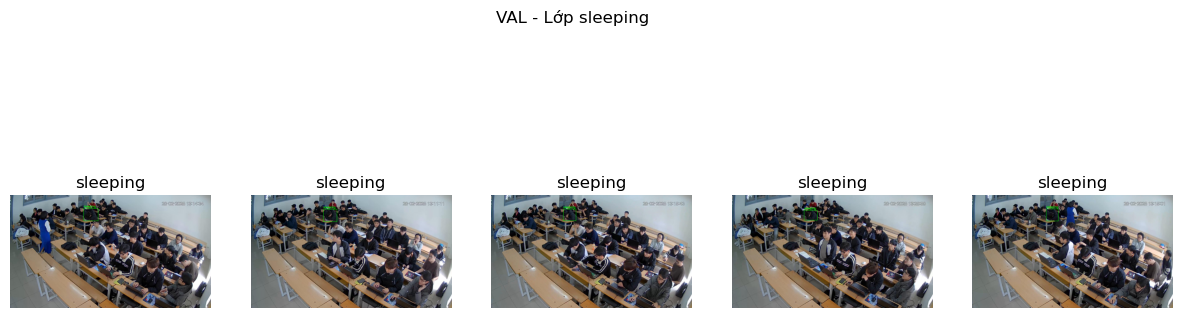

Không có ảnh cho lớp using_computer
Không có ảnh cho lớp using_phone
Không có ảnh cho lớp writing
Visualize số lượng bounding boxes theo lớp cho cả train và validation:


KeyError: 3

In [7]:
import os
import random
import cv2
import matplotlib.pyplot as plt
# Định nghĩa tên lớp theo chỉ số (theo file YAML: nc:3, names: ['hand-raising','read','write'])
class_names = {0: 'drinking', 1: 'raising_hand', 2: 'sleeping', 3: 'using_computer', 4: 'using_phone', 5: 'writing'}

# Đường dẫn tới folder ảnh và label cho train và val
train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/images"
train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/labels"
val_images_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/images"
val_labels_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/labels"
test_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/images"
test_labels_dir ="/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/labels"

# Các định dạng ảnh hợp lệ
valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]


def find_image_file(base_name, images_dir):
    """
    Với base_name (tên file không có phần mở rộng) và thư mục chứa ảnh,
    tìm file ảnh có đuôi hợp lệ và trả về đường dẫn, nếu không tìm thấy trả về None.
    """
    for ext in valid_extensions:
        image_path = os.path.join(images_dir, base_name + ext)
        if os.path.exists(image_path):
            return image_path
    return None

def parse_label_file(label_file):
    """
    Đọc file label (YOLO format) và trả về danh sách các tuple:
    (cls, x_center, y_center, bbox_width, bbox_height)
    """
    boxes = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            x_center, y_center, bw, bh = map(float, parts[1:5])
            boxes.append((cls, x_center, y_center, bw, bh))
    return boxes

def draw_target_boxes(image_path, label_file, target_class):
    """
    Vẽ bounding boxes của target_class lên ảnh.
    Chỉ vẽ các box có lớp (target_class).
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    h, w, _ = image.shape
    boxes = parse_label_file(label_file)
    for box in boxes:
        cls, x_center, y_center, bw, bh = box
        if cls != target_class:
            continue
        # Chuyển tọa độ từ normalized sang pixel
        x_center_pixel = x_center * w
        y_center_pixel = y_center * h
        bw_pixel = bw * w
        bh_pixel = bh * h
        x_min = int(x_center_pixel - bw_pixel / 2)
        y_min = int(y_center_pixel - bh_pixel / 2)
        x_max = int(x_center_pixel + bw_pixel / 2)
        y_max = int(y_center_pixel + bh_pixel / 2)
        # Vẽ box và ghi tên lớp
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, class_names[cls], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def collect_images_by_class(labels_dir, images_dir):
    """
    Duyệt qua tất cả các file label trong folder labels_dir và xây dựng dictionary:
        { class: set( (image_path, label_path) ) }
    Dùng set để tránh trùng lặp nếu ảnh chứa nhiều box của cùng một lớp.
    """
    images_by_class = {0: set(), 1: set(), 2: set()}
    for label_filename in os.listdir(labels_dir):
        if not label_filename.endswith(".txt"):
            continue
        label_file = os.path.join(labels_dir, label_filename)
        base_name = os.path.splitext(label_filename)[0]
        image_file = find_image_file(base_name, images_dir)
        if image_file is None:
            continue
        boxes = parse_label_file(label_file)
        for box in boxes:
            cls = box[0]
            if cls in images_by_class:
                images_by_class[cls].add((image_file, label_file))
    # Chuyển set thành list để dễ thao tác
    for cls in images_by_class:
        images_by_class[cls] = list(images_by_class[cls])
    return images_by_class

def visualize_samples(dataset_type, images_dir, labels_dir):
    """
    Với dataset (train hoặc val), hiển thị 5 mẫu ảnh cho mỗi lớp.
    Chỉ vẽ bounding boxes của lớp đó.
    """
    images_by_class = collect_images_by_class(labels_dir, images_dir)
    for cls in class_names:
        samples = images_by_class.get(cls, [])
        if len(samples) == 0:
            print(f"Không có ảnh cho lớp {class_names[cls]}")
            continue
        # Chọn ngẫu nhiên tối đa 5 mẫu
        selected_samples = random.sample(samples, min(5, len(samples)))
        plt.figure(figsize=(15, 5))
        for i, (img_path, lbl_path) in enumerate(selected_samples):
            img_with_boxes = draw_target_boxes(img_path, lbl_path, cls)
            if img_with_boxes is None:
                continue
            # Chuyển ảnh từ BGR (OpenCV) sang RGB (matplotlib)
            img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i+1)
            plt.imshow(img_rgb)
            plt.title(f"{class_names[cls]}")
            plt.axis('off')
        plt.suptitle(f"{dataset_type.upper()} - Lớp {class_names[cls]}")
        plt.show()

def count_labels(labels_dir):
    """
    Đếm tổng số bounding boxes theo lớp trong folder labels.
    """
    counts = {0: 0, 1: 0, 2: 0}
    for label_filename in os.listdir(labels_dir):
        if not label_filename.endswith(".txt"):
            continue
        label_file = os.path.join(labels_dir, label_filename)
        boxes = parse_label_file(label_file)
        for box in boxes:
            cls = box[0]
            if cls in counts:
                counts[cls] += 1
    return counts

def visualize_label_counts(train_labels_dir, val_labels_dir):
    """
    Visualize số lượng bounding boxes theo lớp cho cả file train và val.
    """
    train_counts = count_labels(train_labels_dir)
    val_counts = count_labels(val_labels_dir)
    
    classes = list(class_names.keys())  # [0, 1, 2]
    class_labels = [class_names[k] for k in classes]
    train_values = [train_counts[k] for k in classes]
    val_values = [val_counts[k] for k in classes]

    x = range(len(classes))
    width = 0.35  # chiều rộng của mỗi cột

    plt.figure(figsize=(10, 6))
    plt.bar(x, train_values, width=width, label='Train', color='skyblue')
    plt.bar([i + width for i in x], val_values, width=width, label='Validation', color='salmon')
    plt.xticks([i + width/2 for i in x], class_labels)
    plt.xlabel("Lớp")
    plt.ylabel("Số lượng bounding boxes")
    plt.title("Số lượng bounding boxes theo lớp trong Train và Validation")
    plt.legend()
    plt.show()

# Visualize samples cho tập train
print("Visualize samples từ tập train:")
visualize_samples("train", train_images_dir, train_labels_dir)

# Visualize samples cho tập val
print("Visualize samples từ tập val:")
visualize_samples("val", val_images_dir, val_labels_dir)

# Visualize số lượng bounding boxes theo lớp cho cả train và val
print("Visualize số lượng bounding boxes theo lớp cho cả train và validation:")
visualize_label_counts(train_labels_dir, val_labels_dir)



## Visualize student

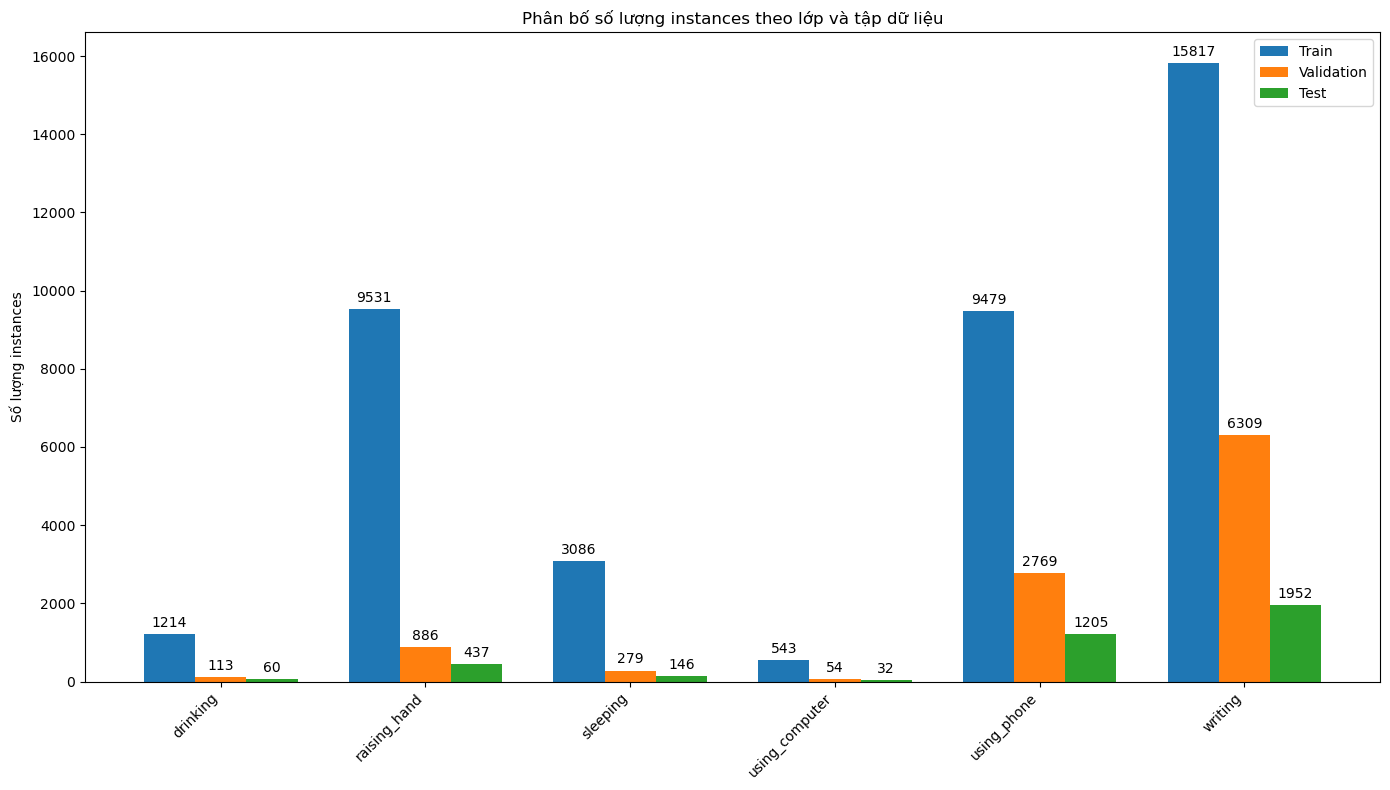

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa các lớp
class_names = {0: 'drinking', 1: 'raising_hand', 2: 'sleeping', 
               3: 'using_computer', 4: 'using_phone', 5: 'writing'}

# Đường dẫn đến các thư mục labels
train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/labels"
val_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/labels"
test_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/labels"

def count_classes(labels_dir):
    """Đếm số lượng objects cho từng class trong thư mục labels"""
    counts = {cls: 0 for cls in class_names.keys()}
    
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(labels_dir, filename), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.strip():
                        cls_id = int(line.strip().split()[0])
                        if cls_id in counts:
                            counts[cls_id] += 1
    return counts

# Lấy số lượng objects cho từng tập
train_counts = count_classes(train_labels_dir)
val_counts = count_classes(val_labels_dir)
test_counts = count_classes(test_labels_dir)

# Chuẩn bị dữ liệu để visualize
classes = sorted(class_names.keys())
class_labels = [class_names[cls] for cls in classes]
train_values = [train_counts[cls] for cls in classes]
val_values = [val_counts[cls] for cls in classes]
test_values = [test_counts[cls] for cls in classes]

x = np.arange(len(class_labels))  # Vị trí các nhãn
width = 0.25  # Độ rộng của các cột

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, train_values, width, label='Train')
rects2 = ax.bar(x, val_values, width, label='Validation')
rects3 = ax.bar(x + width, test_values, width, label='Test')

# Thêm các thành phần cho biểu đồ
ax.set_ylabel('Số lượng instances')
ax.set_title('Phân bố số lượng instances theo lớp và tập dữ liệu')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend()

# Hiển thị số trên mỗi cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## SCB

Visualize samples từ tập train:


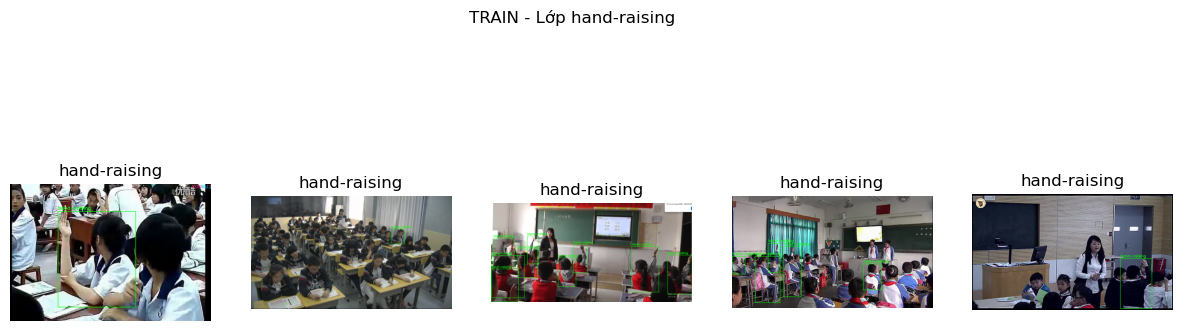

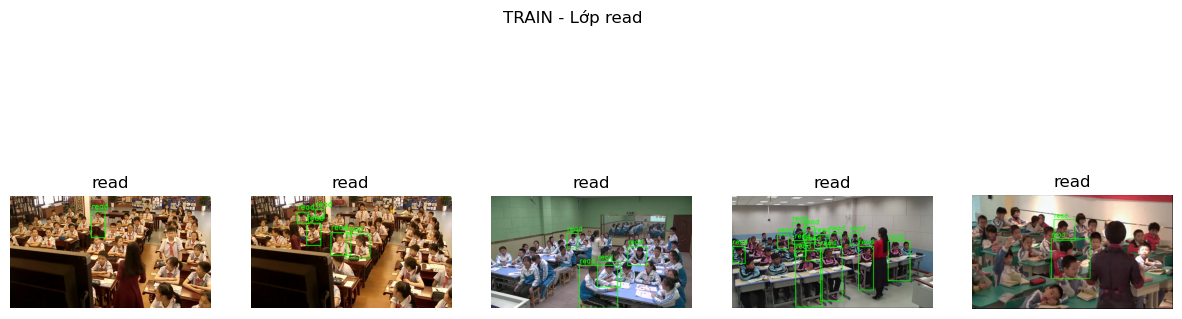

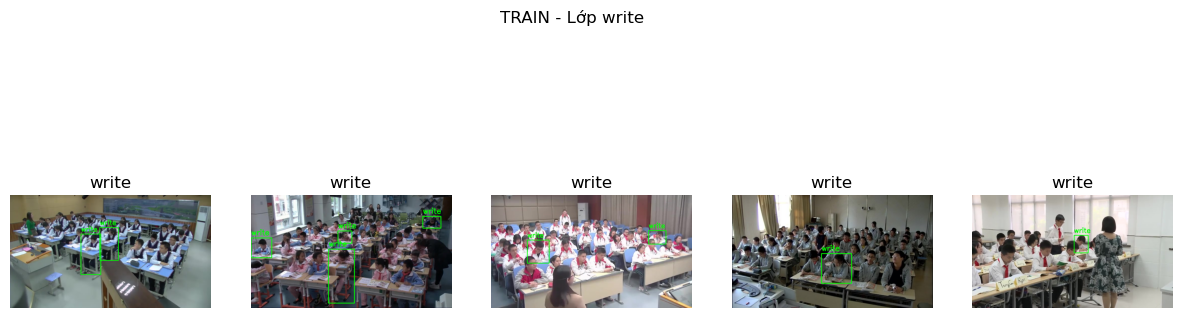

Visualize samples từ tập val:


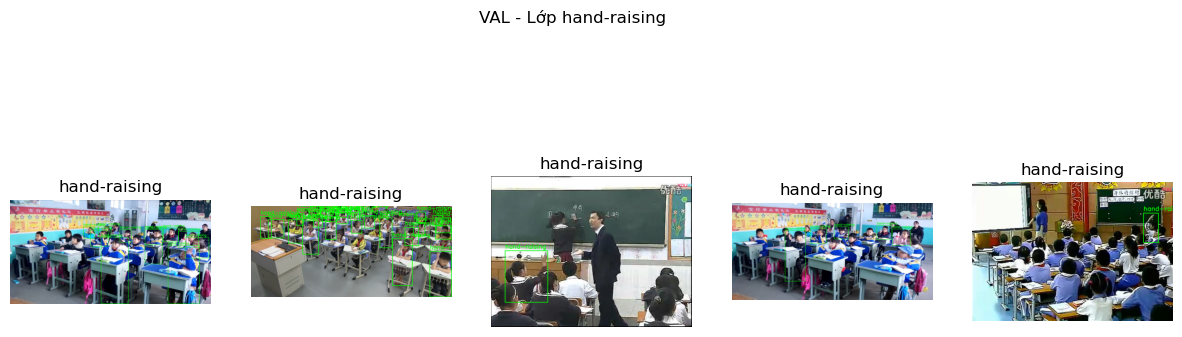

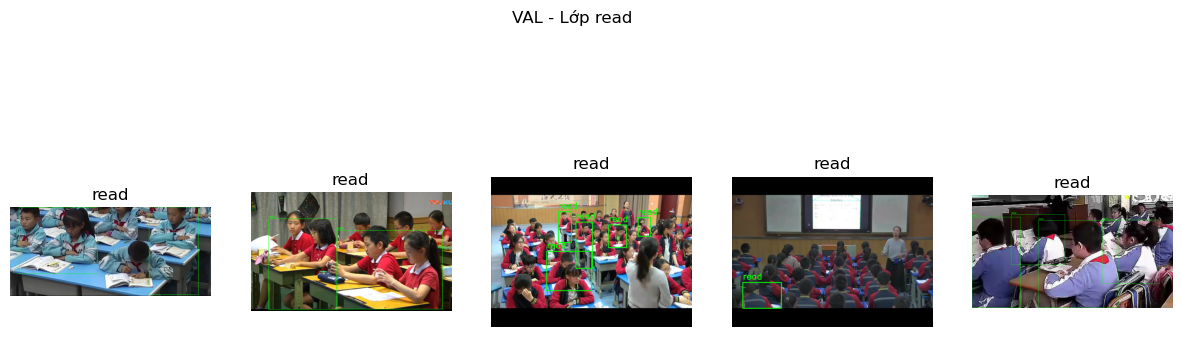

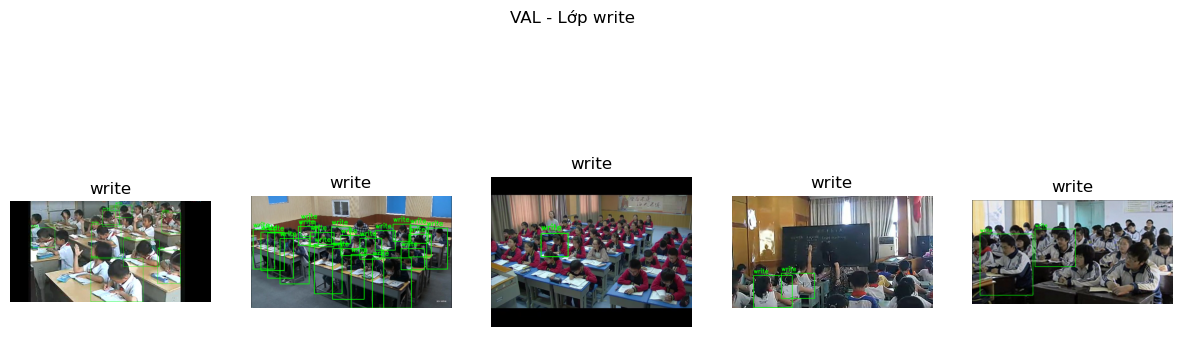

Visualize số lượng bounding boxes theo lớp cho cả train và validation:


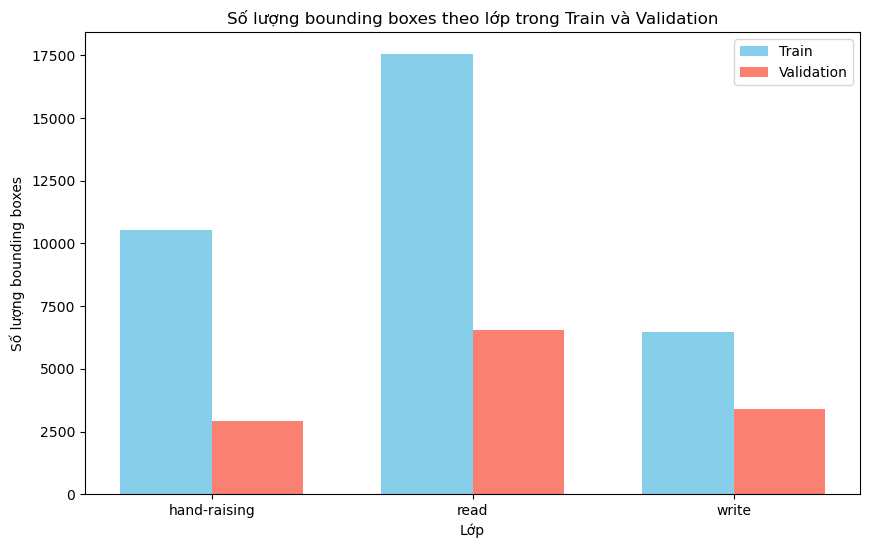

In [6]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Định nghĩa tên lớp theo chỉ số (theo file YAML: nc:3, names: ['hand-raising','read','write'])
class_names = {0: 'hand-raising', 1: 'read', 2: 'write'}

# Đường dẫn tới folder ảnh và label cho train và val
train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/train"
train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/train"
val_images_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/val"
val_labels_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/val"

# Các định dạng ảnh hợp lệ
valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

def find_image_file(base_name, images_dir):
    """
    Với base_name (tên file không có phần mở rộng) và thư mục chứa ảnh,
    tìm file ảnh có đuôi hợp lệ và trả về đường dẫn, nếu không tìm thấy trả về None.
    """
    for ext in valid_extensions:
        image_path = os.path.join(images_dir, base_name + ext)
        if os.path.exists(image_path):
            return image_path
    return None

def parse_label_file(label_file):
    """
    Đọc file label (YOLO format) và trả về danh sách các tuple:
    (cls, x_center, y_center, bbox_width, bbox_height)
    """
    boxes = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            x_center, y_center, bw, bh = map(float, parts[1:5])
            boxes.append((cls, x_center, y_center, bw, bh))
    return boxes

def draw_target_boxes(image_path, label_file, target_class):
    """
    Vẽ bounding boxes của target_class lên ảnh.
    Chỉ vẽ các box có lớp (target_class).
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    h, w, _ = image.shape
    boxes = parse_label_file(label_file)
    for box in boxes:
        cls, x_center, y_center, bw, bh = box
        if cls != target_class:
            continue
        # Chuyển tọa độ từ normalized sang pixel
        x_center_pixel = x_center * w
        y_center_pixel = y_center * h
        bw_pixel = bw * w
        bh_pixel = bh * h
        x_min = int(x_center_pixel - bw_pixel / 2)
        y_min = int(y_center_pixel - bh_pixel / 2)
        x_max = int(x_center_pixel + bw_pixel / 2)
        y_max = int(y_center_pixel + bh_pixel / 2)
        # Vẽ box và ghi tên lớp
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, class_names[cls], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def collect_images_by_class(labels_dir, images_dir):
    """
    Duyệt qua tất cả các file label trong folder labels_dir và xây dựng dictionary:
        { class: set( (image_path, label_path) ) }
    Dùng set để tránh trùng lặp nếu ảnh chứa nhiều box của cùng một lớp.
    """
    images_by_class = {0: set(), 1: set(), 2: set()}
    for label_filename in os.listdir(labels_dir):
        if not label_filename.endswith(".txt"):
            continue
        label_file = os.path.join(labels_dir, label_filename)
        base_name = os.path.splitext(label_filename)[0]
        image_file = find_image_file(base_name, images_dir)
        if image_file is None:
            continue
        boxes = parse_label_file(label_file)
        for box in boxes:
            cls = box[0]
            if cls in images_by_class:
                images_by_class[cls].add((image_file, label_file))
    # Chuyển set thành list để dễ thao tác
    for cls in images_by_class:
        images_by_class[cls] = list(images_by_class[cls])
    return images_by_class

def visualize_samples(dataset_type, images_dir, labels_dir):
    """
    Với dataset (train hoặc val), hiển thị 5 mẫu ảnh cho mỗi lớp.
    Chỉ vẽ bounding boxes của lớp đó.
    """
    images_by_class = collect_images_by_class(labels_dir, images_dir)
    for cls in class_names:
        samples = images_by_class.get(cls, [])
        if len(samples) == 0:
            print(f"Không có ảnh cho lớp {class_names[cls]}")
            continue
        # Chọn ngẫu nhiên tối đa 5 mẫu
        selected_samples = random.sample(samples, min(5, len(samples)))
        plt.figure(figsize=(15, 5))
        for i, (img_path, lbl_path) in enumerate(selected_samples):
            img_with_boxes = draw_target_boxes(img_path, lbl_path, cls)
            if img_with_boxes is None:
                continue
            # Chuyển ảnh từ BGR (OpenCV) sang RGB (matplotlib)
            img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i+1)
            plt.imshow(img_rgb)
            plt.title(f"{class_names[cls]}")
            plt.axis('off')
        plt.suptitle(f"{dataset_type.upper()} - Lớp {class_names[cls]}")
        plt.show()

def count_labels(labels_dir):
    """
    Đếm tổng số bounding boxes theo lớp trong folder labels.
    """
    counts = {0: 0, 1: 0, 2: 0}
    for label_filename in os.listdir(labels_dir):
        if not label_filename.endswith(".txt"):
            continue
        label_file = os.path.join(labels_dir, label_filename)
        boxes = parse_label_file(label_file)
        for box in boxes:
            cls = box[0]
            if cls in counts:
                counts[cls] += 1
    return counts

def visualize_label_counts(train_labels_dir, val_labels_dir):
    """
    Visualize số lượng bounding boxes theo lớp cho cả file train và val.
    """
    train_counts = count_labels(train_labels_dir)
    val_counts = count_labels(val_labels_dir)
    
    classes = list(class_names.keys())  # [0, 1, 2]
    class_labels = [class_names[k] for k in classes]
    train_values = [train_counts[k] for k in classes]
    val_values = [val_counts[k] for k in classes]

    x = range(len(classes))
    width = 0.35  # chiều rộng của mỗi cột

    plt.figure(figsize=(10, 6))
    plt.bar(x, train_values, width=width, label='Train', color='skyblue')
    plt.bar([i + width for i in x], val_values, width=width, label='Validation', color='salmon')
    plt.xticks([i + width/2 for i in x], class_labels)
    plt.xlabel("Lớp")
    plt.ylabel("Số lượng bounding boxes")
    plt.title("Số lượng bounding boxes theo lớp trong Train và Validation")
    plt.legend()
    plt.show()

# Visualize samples cho tập train
print("Visualize samples từ tập train:")
visualize_samples("train", train_images_dir, train_labels_dir)

# Visualize samples cho tập val
print("Visualize samples từ tập val:")
visualize_samples("val", val_images_dir, val_labels_dir)

# Visualize số lượng bounding boxes theo lớp cho cả train và val
print("Visualize số lượng bounding boxes theo lớp cho cả train và validation:")
visualize_label_counts(train_labels_dir, val_labels_dir)


### Di chuyển 10% train và 5% valid sang test

In [3]:
import os
import random
import shutil

# Đường dẫn tới folder images và labels của train, valid và test
train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/train"
train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/train"
val_images_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/val"
val_labels_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/val"


# Folder đích cho tập test
test_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/test"
test_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/test"

# Tạo folder test nếu chưa tồn tại
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Các định dạng ảnh hợp lệ
valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

def move_sample(src_images_dir, src_labels_dir, dest_images_dir, dest_labels_dir, percent):
    """
    Di chuyển ngẫu nhiên một tỉ lệ percent (%) ảnh từ src_images_dir sang dest_images_dir,
    đồng thời di chuyển file label tương ứng từ src_labels_dir sang dest_labels_dir nếu có.
    """
    # Lấy danh sách file ảnh có định dạng hợp lệ trong src_images_dir
    all_images = [f for f in os.listdir(src_images_dir) if os.path.splitext(f)[1].lower() in valid_extensions]
    
    # Xác định số lượng ảnh cần di chuyển
    sample_count = int(len(all_images) * percent / 100)
    print(f"Từ {src_images_dir}: {len(all_images)} ảnh, sẽ di chuyển {sample_count} ảnh ({percent}%).")
    
    # Lấy mẫu ngẫu nhiên
    sample_images = random.sample(all_images, sample_count)
    
    for image_file in sample_images:
        # Di chuyển file ảnh
        src_image_path = os.path.join(src_images_dir, image_file)
        dest_image_path = os.path.join(dest_images_dir, image_file)
        shutil.move(src_image_path, dest_image_path)
        
        # Di chuyển file label tương ứng (nếu có)
        base_name = os.path.splitext(image_file)[0]
        label_file = base_name + ".txt"
        src_label_path = os.path.join(src_labels_dir, label_file)
        if os.path.exists(src_label_path):
            dest_label_path = os.path.join(dest_labels_dir, label_file)
            shutil.move(src_label_path, dest_label_path)

# Di chuyển 10% từ train sang test
move_sample(train_images_dir, train_labels_dir, test_images_dir, test_labels_dir, 10)

# Di chuyển 5% từ valid sang test
move_sample(val_images_dir, val_labels_dir, test_images_dir, test_labels_dir, 5)


Từ /hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/train: 5193 ảnh, sẽ di chuyển 519 ảnh (10%).
Từ /hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/val: 1671 ảnh, sẽ di chuyển 83 ảnh (5%).


### THống kê train, valid, test

Visualize samples từ tập train:


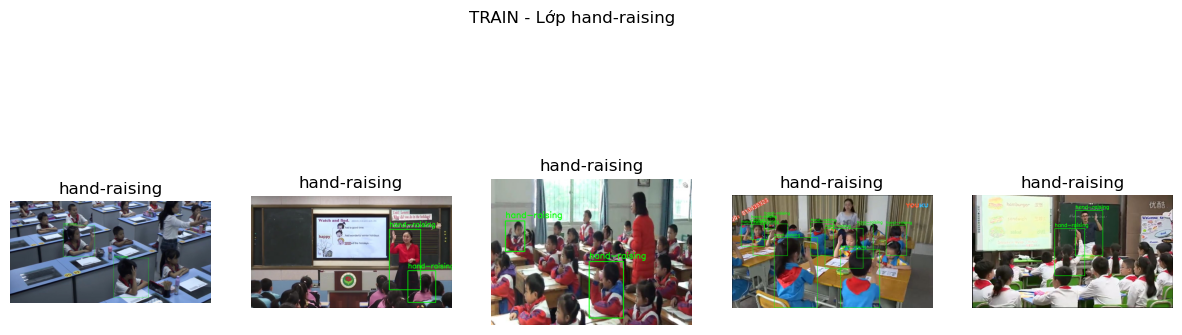

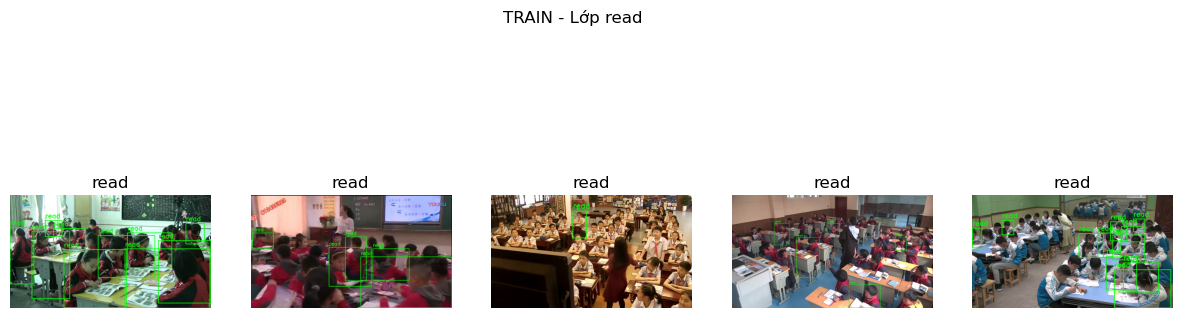

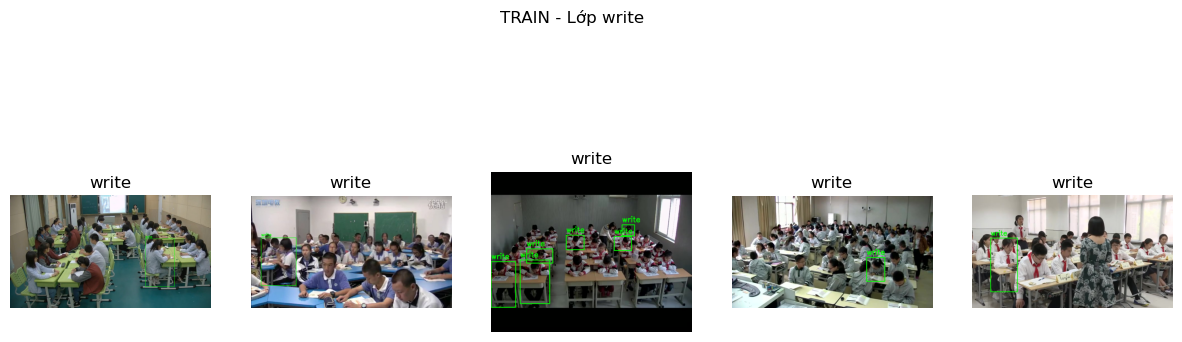

Visualize samples từ tập val:


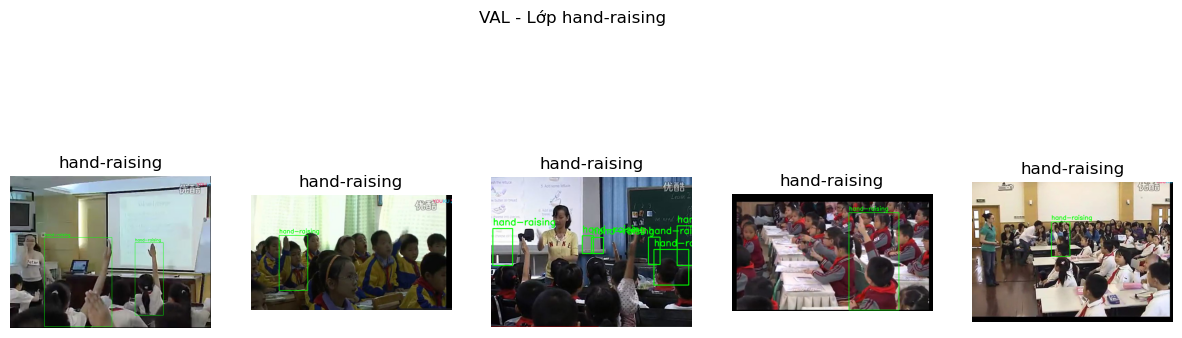

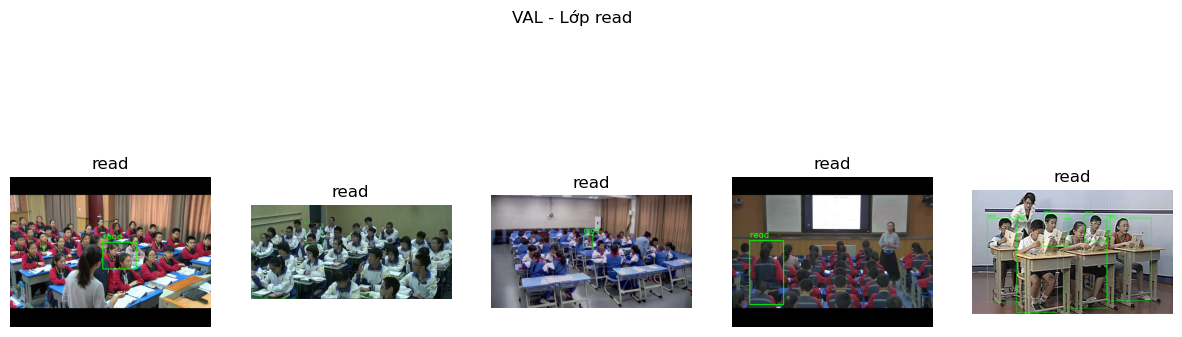

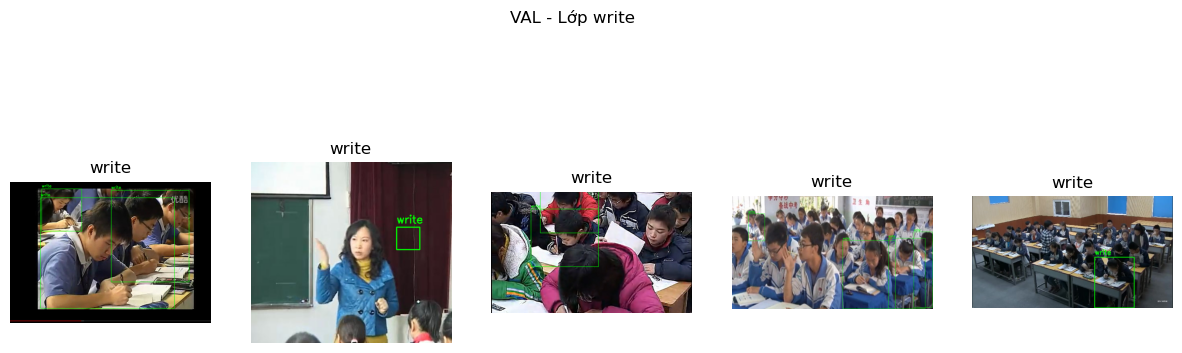

Visualize samples từ tập test:


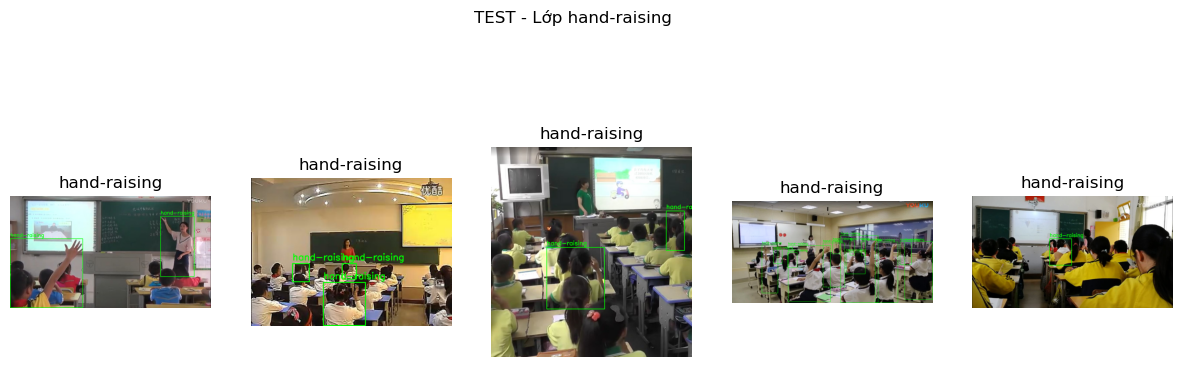

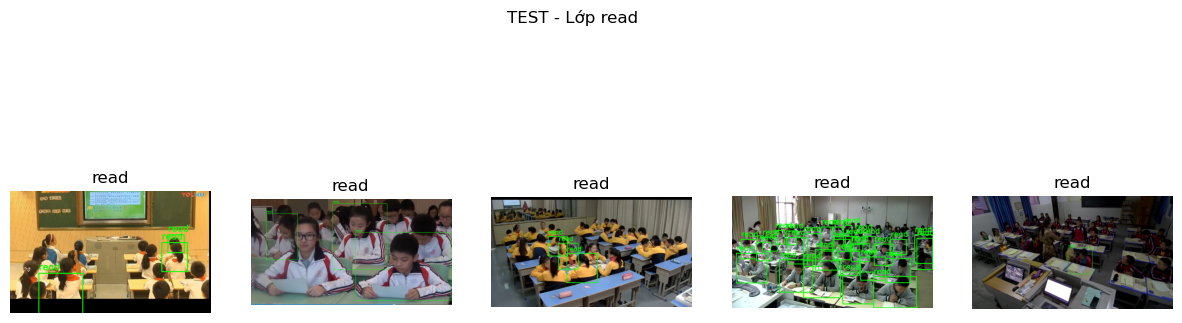

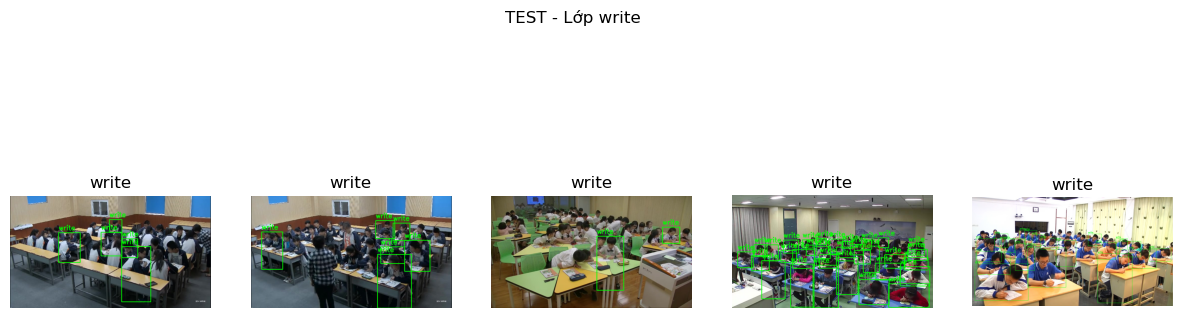

Visualize số lượng bounding boxes theo lớp cho Train và Validation:


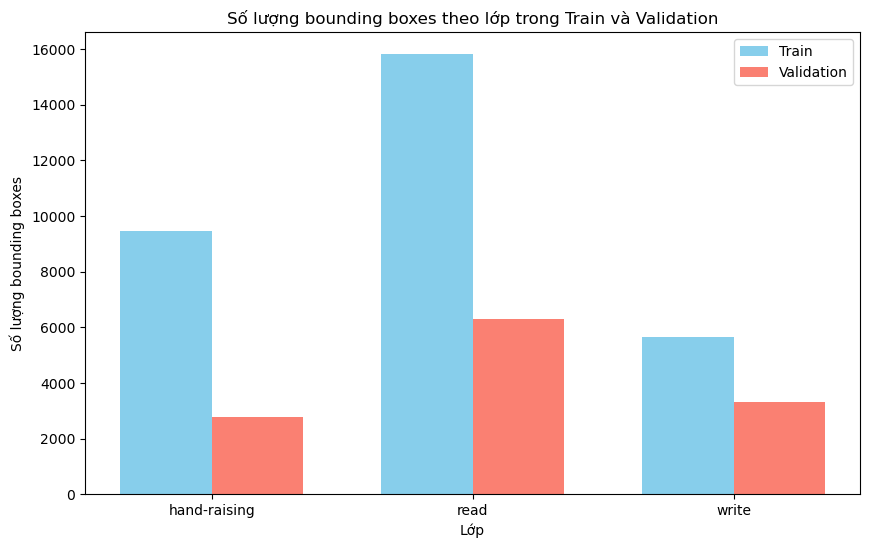

Visualize số lượng bounding boxes theo lớp cho Train, Validation và Test:


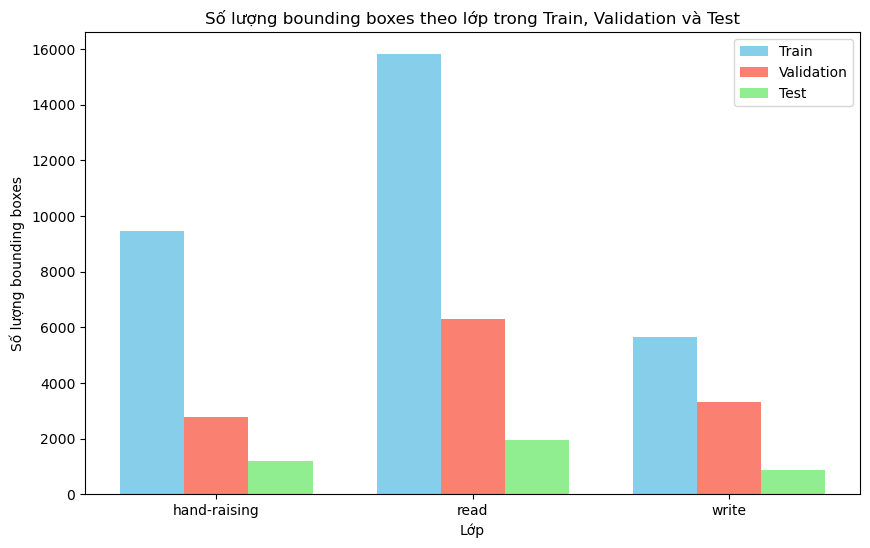

In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Định nghĩa tên lớp theo chỉ số (theo file YAML: nc:3, names: ['hand-raising','read','write'])
class_names = {0: 'hand-raising', 1: 'read', 2: 'write'}

# Đường dẫn tới folder ảnh và label cho train, val và test
# Đường dẫn tới folder images và labels của train, valid và test
train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/train"
train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/train"
val_images_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/val"
val_labels_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/val"


# Folder đích cho tập test
test_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/test"
test_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/test"

# Các định dạng ảnh hợp lệ
valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

def find_image_file(base_name, images_dir):
    """
    Với base_name (tên file không có phần mở rộng) và thư mục chứa ảnh,
    tìm file ảnh có đuôi hợp lệ và trả về đường dẫn, nếu không tìm thấy trả về None.
    """
    for ext in valid_extensions:
        image_path = os.path.join(images_dir, base_name + ext)
        if os.path.exists(image_path):
            return image_path
    return None

def parse_label_file(label_file):
    """
    Đọc file label (YOLO format) và trả về danh sách các tuple:
    (cls, x_center, y_center, bbox_width, bbox_height)
    """
    boxes = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            x_center, y_center, bw, bh = map(float, parts[1:5])
            boxes.append((cls, x_center, y_center, bw, bh))
    return boxes

def draw_target_boxes(image_path, label_file, target_class):
    """
    Vẽ bounding boxes của target_class lên ảnh.
    Chỉ vẽ các box có lớp (target_class).
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    h, w, _ = image.shape
    boxes = parse_label_file(label_file)
    for box in boxes:
        cls, x_center, y_center, bw, bh = box
        if cls != target_class:
            continue
        # Chuyển tọa độ từ normalized sang pixel
        x_center_pixel = x_center * w
        y_center_pixel = y_center * h
        bw_pixel = bw * w
        bh_pixel = bh * h
        x_min = int(x_center_pixel - bw_pixel / 2)
        y_min = int(y_center_pixel - bh_pixel / 2)
        x_max = int(x_center_pixel + bw_pixel / 2)
        y_max = int(y_center_pixel + bh_pixel / 2)
        # Vẽ box và ghi tên lớp
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, class_names[cls], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def collect_images_by_class(labels_dir, images_dir):
    """
    Duyệt qua tất cả các file label trong folder labels_dir và xây dựng dictionary:
        { class: set( (image_path, label_path) ) }
    Dùng set để tránh trùng lặp nếu ảnh chứa nhiều box của cùng một lớp.
    """
    images_by_class = {0: set(), 1: set(), 2: set()}
    for label_filename in os.listdir(labels_dir):
        if not label_filename.endswith(".txt"):
            continue
        label_file = os.path.join(labels_dir, label_filename)
        base_name = os.path.splitext(label_filename)[0]
        image_file = find_image_file(base_name, images_dir)
        if image_file is None:
            continue
        boxes = parse_label_file(label_file)
        for box in boxes:
            cls = box[0]
            if cls in images_by_class:
                images_by_class[cls].add((image_file, label_file))
    # Chuyển set thành list để dễ thao tác
    for cls in images_by_class:
        images_by_class[cls] = list(images_by_class[cls])
    return images_by_class

def visualize_samples(dataset_type, images_dir, labels_dir):
    """
    Với dataset (train, val hoặc test), hiển thị 5 mẫu ảnh cho mỗi lớp.
    Chỉ vẽ bounding boxes của lớp đó.
    """
    images_by_class = collect_images_by_class(labels_dir, images_dir)
    for cls in class_names:
        samples = images_by_class.get(cls, [])
        if len(samples) == 0:
            print(f"Không có ảnh cho lớp {class_names[cls]} ở dataset {dataset_type}")
            continue
        # Chọn ngẫu nhiên tối đa 5 mẫu
        selected_samples = random.sample(samples, min(5, len(samples)))
        plt.figure(figsize=(15, 5))
        for i, (img_path, lbl_path) in enumerate(selected_samples):
            img_with_boxes = draw_target_boxes(img_path, lbl_path, cls)
            if img_with_boxes is None:
                continue
            # Chuyển ảnh từ BGR (OpenCV) sang RGB (matplotlib)
            img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i+1)
            plt.imshow(img_rgb)
            plt.title(f"{class_names[cls]}")
            plt.axis('off')
        plt.suptitle(f"{dataset_type.upper()} - Lớp {class_names[cls]}")
        plt.show()

def count_labels(labels_dir):
    """
    Đếm tổng số bounding boxes theo lớp trong folder labels.
    """
    counts = {0: 0, 1: 0, 2: 0}
    for label_filename in os.listdir(labels_dir):
        if not label_filename.endswith(".txt"):
            continue
        label_file = os.path.join(labels_dir, label_filename)
        boxes = parse_label_file(label_file)
        for box in boxes:
            cls = box[0]
            if cls in counts:
                counts[cls] += 1
    return counts

def visualize_label_counts(train_labels_dir, val_labels_dir):
    """
    Visualize số lượng bounding boxes theo lớp cho cả train và validation.
    """
    train_counts = count_labels(train_labels_dir)
    val_counts = count_labels(val_labels_dir)
    
    classes = list(class_names.keys())  # [0, 1, 2]
    class_labels = [class_names[k] for k in classes]
    train_values = [train_counts[k] for k in classes]
    val_values = [val_counts[k] for k in classes]

    x = range(len(classes))
    width = 0.35  # chiều rộng của mỗi cột

    plt.figure(figsize=(10, 6))
    plt.bar(x, train_values, width=width, label='Train', color='skyblue')
    plt.bar([i + width for i in x], val_values, width=width, label='Validation', color='salmon')
    plt.xticks([i + width/2 for i in x], class_labels)
    plt.xlabel("Lớp")
    plt.ylabel("Số lượng bounding boxes")
    plt.title("Số lượng bounding boxes theo lớp trong Train và Validation")
    plt.legend()
    plt.show()

def visualize_all_label_counts(train_labels_dir, val_labels_dir, test_labels_dir):
    """
    Visualize số lượng bounding boxes theo lớp cho cả Train, Validation và Test.
    """
    train_counts = count_labels(train_labels_dir)
    val_counts = count_labels(val_labels_dir)
    test_counts = count_labels(test_labels_dir)
    
    classes = list(class_names.keys())
    class_labels = [class_names[k] for k in classes]
    train_values = [train_counts[k] for k in classes]
    val_values = [val_counts[k] for k in classes]
    test_values = [test_counts[k] for k in classes]

    x = range(len(classes))
    width = 0.25  # giảm chiều rộng vì có 3 nhóm cột

    plt.figure(figsize=(10, 6))
    plt.bar([i - width for i in x], train_values, width=width, label='Train', color='skyblue')
    plt.bar(x, val_values, width=width, label='Validation', color='salmon')
    plt.bar([i + width for i in x], test_values, width=width, label='Test', color='lightgreen')
    plt.xticks(x, class_labels)
    plt.xlabel("Lớp")
    plt.ylabel("Số lượng bounding boxes")
    plt.title("Số lượng bounding boxes theo lớp trong Train, Validation và Test")
    plt.legend()
    plt.show()

# Visualize samples cho từng dataset
print("Visualize samples từ tập train:")
visualize_samples("train", train_images_dir, train_labels_dir)

print("Visualize samples từ tập val:")
visualize_samples("val", val_images_dir, val_labels_dir)

print("Visualize samples từ tập test:")
visualize_samples("test", test_images_dir, test_labels_dir)

# Visualize số lượng bounding boxes theo lớp cho Train và Validation
print("Visualize số lượng bounding boxes theo lớp cho Train và Validation:")
visualize_label_counts(train_labels_dir, val_labels_dir)

# Visualize số lượng bounding boxes theo lớp cho Train, Validation và Test
print("Visualize số lượng bounding boxes theo lớp cho Train, Validation và Test:")
visualize_all_label_counts(train_labels_dir, val_labels_dir, test_labels_dir)


**Bây giờ tôi muốn map. giữa dataset Student và dataset**
- SCB: Ở Student có ['drinking', 'raising_hand', 'sleeping', 'using_computer', 'using_phone', 'writing'] Ở SCB 
- có  ['hand-raising','read','write']. Map giữa hand-raising vào raising_hand, write vào writing. 
- Ý muốn của tôi là merge SCB vào Student

In [25]:
import os
import shutil

# Mapping của từng dataset
student_mapping = {
    0: 'drinking',
    1: 'raising_hand',
    2: 'sleeping',
    3: 'using_computer',
    4: 'using_phone',
    5: 'writing'
}

scb_mapping = {
    0: 'hand-raising',  # sẽ map sang 'raising_hand'
    1: 'read',
    2: 'write'          # sẽ map sang 'writing'
}

# Unified mapping: sử dụng định nghĩa của Student, bổ sung lớp 'read'
unified_mapping = {
    'drinking': 0,
    'raising_hand': 1,
    'sleeping': 2,
    'using_computer': 3,
    'using_phone': 4,
    'writing': 5,
    'read': 6
}

def update_scb_annotation_line(line):
    """
    Chuyển đổi một dòng annotation của SCB sang unified mapping.
    Dòng annotation có định dạng: "cls x_center y_center width height"
    """
    parts = line.strip().split()
    if len(parts) < 5:
        return line  # nếu dòng không hợp lệ
    orig_cls = int(parts[0])
    
    # Lấy tên nhãn theo SCB
    class_name = scb_mapping.get(orig_cls)
    if class_name is None:
        return line
    
    # Map tên nhãn:
    # hand-raising -> raising_hand, write -> writing (read giữ nguyên)
    if class_name == 'hand-raising':
        class_name = 'raising_hand'
    elif class_name == 'write':
        class_name = 'writing'
    
    # Lấy số nhãn mới theo unified_mapping
    new_cls = unified_mapping.get(class_name)
    parts[0] = str(new_cls)
    return " ".join(parts)

def process_scb_annotations(scb_labels_dir, output_labels_dir):
    """
    Chuyển đổi toàn bộ file annotation của SCB và lưu vào output_labels_dir.
    """
    if not os.path.exists(output_labels_dir):
        os.makedirs(output_labels_dir)
    for filename in os.listdir(scb_labels_dir):
        if not filename.endswith(".txt"):
            continue
        input_path = os.path.join(scb_labels_dir, filename)
        output_path = os.path.join(output_labels_dir, filename)
        with open(input_path, 'r') as f:
            lines = f.readlines()
        updated_lines = [update_scb_annotation_line(line) for line in lines]
        with open(output_path, 'w') as f:
            f.write("\n".join(updated_lines))
        print(f"Processed annotation: {filename}")

def merge_scb_images(scb_images_dir, dest_images_dir):
    """
    Copy toàn bộ ảnh từ SCB sang dest_images_dir.
    """
    if not os.path.exists(dest_images_dir):
        os.makedirs(dest_images_dir)
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]
    for filename in os.listdir(scb_images_dir):
        ext = os.path.splitext(filename)[1].lower()
        if ext in valid_extensions:
            src_path = os.path.join(scb_images_dir, filename)
            dest_path = os.path.join(dest_images_dir, filename)
            shutil.copy(src_path, dest_path)
            print(f"Copied image: {filename}")

# Ví dụ đường dẫn:
# Dataset Student (đã có sẵn)
# Đường dẫn tới folder ảnh và label cho train và val
train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/images"
train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/labels"
val_images_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/images"
val_labels_dir   = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/labels"
test_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/images"
test_labels_dir ="/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/labels"

# Dataset SCB ban đầu
train_scb_labels_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/labels/train"
train_scb_images_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/images/train"
valid_scb_labels_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/labels/valid"
valid_scb_images_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/images/valid"
test_scb_labels_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/labels/test"
test_scb_images_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/images/test"

# Folder output cho dataset merged (Student đã merge SCB)
merged_labels_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/merged_dataset/labels"
merged_images_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/merged_dataset/images"

# Bước 1: Copy file annotation của Student sang merged (nếu cần)
# Nếu Student đã sử dụng unified mapping thì có thể giữ nguyên.
if not os.path.exists(merged_labels_dir):
    os.makedirs(merged_labels_dir)
for filename in os.listdir(student_labels_dir):
    if filename.endswith(".txt"):
        shutil.copy(os.path.join(student_labels_dir, filename),
                    os.path.join(merged_labels_dir, filename))

# Bước 2: Process annotation của SCB và copy vào merged
process_scb_annotations(scb_labels_dir, merged_labels_dir)

# Bước 3: Copy ảnh của Student sang merged (nếu chưa có)
if not os.path.exists(merged_images_dir):
    os.makedirs(merged_images_dir)
for filename in os.listdir(student_images_dir):
    ext = os.path.splitext(filename)[1].lower()
    if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
        shutil.copy(os.path.join(student_images_dir, filename),
                    os.path.join(merged_images_dir, filename))

# Bước 4: Copy ảnh của SCB sang merged
merge_scb_images(scb_images_dir, merged_images_dir)

print("Merge dataset thành công!")


Merge dataset thành công!


### Visulize sau khi merge

Visualize sample images with bounding boxes...


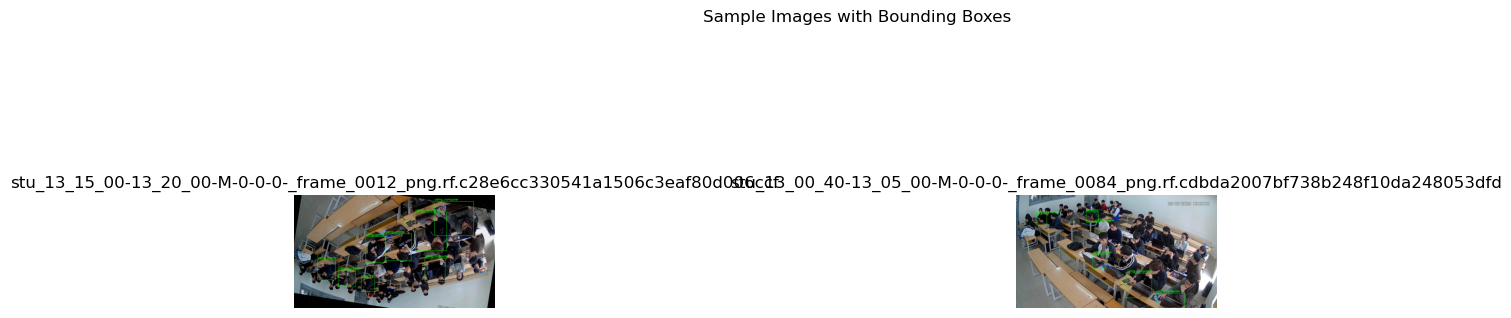

Số lượng bounding boxes theo lớp: Counter({6: 24078, 3: 19103, 1: 13476, 5: 10930, 4: 5632, 2: 2699, 0: 58})


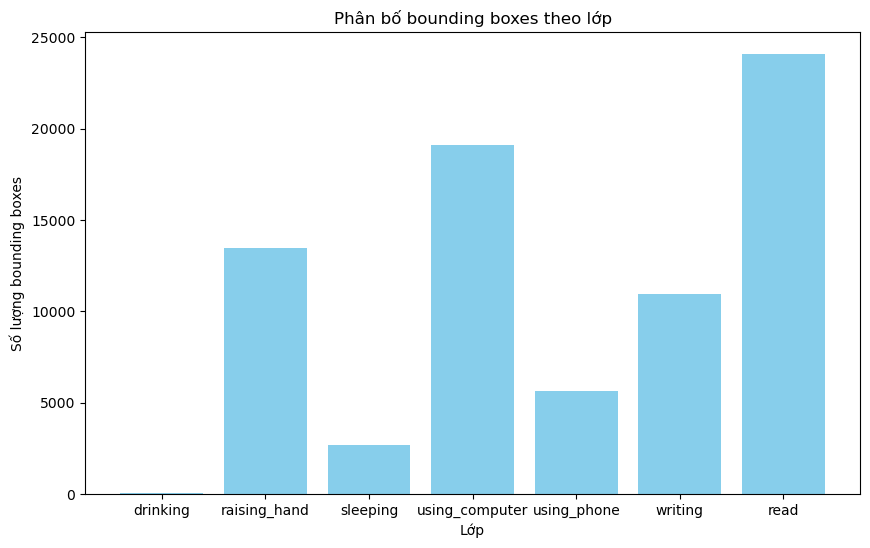

In [23]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from collections import Counter


merged_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/merged_dataset_student_scb/labels"
merged_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/merged_dataset_student_scb/images"

# Các định dạng ảnh hợp lệ
valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

# Unified class mapping (theo định nghĩa của Student, bổ sung read từ SCB)
class_names = {
    0: 'drinking',
    1: 'raising_hand',
    2: 'sleeping',
    3: 'using_computer',
    4: 'using_phone',
    5: 'writing',
    6: 'read'
}

def find_image_file(base_name, images_dir):
    """
    Tìm file ảnh có tên base_name với các định dạng hợp lệ.
    """
    for ext in valid_extensions:
        image_path = os.path.join(images_dir, base_name + ext)
        if os.path.exists(image_path):
            return image_path
    return None

def parse_label_file(label_file):
    """
    Đọc file label (YOLO format) và trả về danh sách các tuple:
    (cls, x_center, y_center, bbox_width, bbox_height)
    """
    boxes = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            x_center, y_center, bw, bh = map(float, parts[1:5])
            boxes.append((cls, x_center, y_center, bw, bh))
    return boxes

def draw_bounding_boxes(image, boxes):
    """
    Vẽ tất cả các bounding box lên ảnh dựa trên danh sách boxes.
    Các giá trị trong boxes được giả định là normalized (0-1).
    """
    h, w, _ = image.shape
    for box in boxes:
        cls, x_center, y_center, bw, bh = box
        # Chuyển tọa độ từ normalized sang pixel
        x_center_pixel = x_center * w
        y_center_pixel = y_center * h
        bw_pixel = bw * w
        bh_pixel = bh * h
        x_min = int(x_center_pixel - bw_pixel / 2)
        y_min = int(y_center_pixel - bh_pixel / 2)
        x_max = int(x_center_pixel + bw_pixel / 2)
        y_max = int(y_center_pixel + bh_pixel / 2)
        # Vẽ bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Hiển thị tên lớp
        label_text = class_names.get(cls, str(cls))
        cv2.putText(image, label_text, (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def visualize_samples(images_dir, labels_dir, sample_count=5):
    """
    Chọn ngẫu nhiên một số file label từ dataset, sau đó vẽ bounding box lên ảnh mẫu.
    """
    # Lấy danh sách file label
    label_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]
    if not label_files:
        print("Không tìm thấy file label nào.")
        return
    selected_files = random.sample(label_files, min(sample_count, len(label_files)))
    
    plt.figure(figsize=(15, 5))
    for i, label_file in enumerate(selected_files):
        base_name = os.path.splitext(label_file)[0]
        image_path = find_image_file(base_name, images_dir)
        if image_path is None:
            continue
        full_label_path = os.path.join(labels_dir, label_file)
        boxes = parse_label_file(full_label_path)
        img = cv2.imread(image_path)
        if img is None:
            continue
        img_with_boxes = draw_bounding_boxes(img.copy(), boxes)
        # Chuyển từ BGR sang RGB để hiển thị với matplotlib
        img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
        plt.subplot(1, sample_count, i + 1)
        plt.imshow(img_rgb)
        plt.title(base_name)
        plt.axis('off')
    plt.suptitle("Sample Images with Bounding Boxes")
    plt.show()

def count_all_labels(labels_dir):
    """
    Đếm số bounding box theo lớp từ tất cả các file label trong folder.
    """
    counts = Counter()
    label_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]
    for label_file in label_files:
        full_label_path = os.path.join(labels_dir, label_file)
        boxes = parse_label_file(full_label_path)
        for box in boxes:
            cls = box[0]
            counts[cls] += 1
    return counts

def visualize_label_counts(counts):
    """
    Visualize số lượng bounding boxes theo lớp dưới dạng biểu đồ cột.
    """
    # Sắp xếp các lớp theo thứ tự key
    classes = sorted(counts.keys())
    class_labels = [class_names.get(c, str(c)) for c in classes]
    values = [counts[c] for c in classes]
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, values, color='skyblue')
    plt.xlabel("Lớp")
    plt.ylabel("Số lượng bounding boxes")
    plt.title("Phân bố bounding boxes theo lớp")
    plt.show()

if __name__ == "__main__":
    # Visualize mẫu ảnh kèm bounding box
    print("Visualize sample images with bounding boxes...")
    visualize_samples(merged_images_dir, merged_labels_dir, sample_count=5)

    # Đếm số bounding box theo lớp
    counts = count_all_labels(merged_labels_dir)
    print("Số lượng bounding boxes theo lớp:", counts)

    # Visualize biểu đồ số lượng bounding box theo lớp
    visualize_label_counts(counts)


## Cải tiến merge cả train, valid, test. Có check validate, thống kê

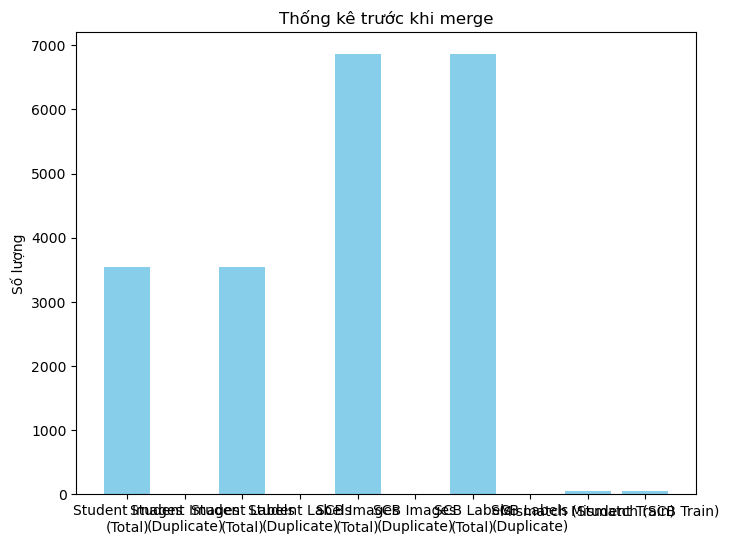

INFO: Processed SCB annotation: 1424007.txt
INFO: Processed SCB annotation: 1262016.txt
INFO: Processed SCB annotation: 1000062.txt
INFO: Processed SCB annotation: 0013005.txt
INFO: Processed SCB annotation: 0081_001792.txt
INFO: Processed SCB annotation: 9_001110.txt
INFO: Processed SCB annotation: 1429041.txt
INFO: Processed SCB annotation: 3005124.txt
INFO: Processed SCB annotation: 12_001362.txt
INFO: Processed SCB annotation: 3005298.txt
INFO: Processed SCB annotation: 15_002004.txt
INFO: Processed SCB annotation: 3004055.txt
INFO: Processed SCB annotation: 133_000731.txt
INFO: Processed SCB annotation: 1358001.txt
INFO: Processed SCB annotation: 3005161.txt
INFO: Processed SCB annotation: 3004102.txt
INFO: Processed SCB annotation: 0105021.txt
INFO: Processed SCB annotation: 18_000752.txt
INFO: Processed SCB annotation: 1297032.txt
INFO: Processed SCB annotation: 130_001520.txt
INFO: Processed SCB annotation: 21_001745.txt
INFO: Processed SCB annotation: 1311024.txt
INFO: Process

INFO: Processed SCB annotation: 57_002202.txt
INFO: Processed SCB annotation: 1130022.txt
INFO: Processed SCB annotation: 0800031.txt
INFO: Processed SCB annotation: 19_000793.txt
INFO: Processed SCB annotation: 1265039.txt
INFO: Processed SCB annotation: 15_000419.txt
INFO: Processed SCB annotation: 0400016.txt
INFO: Processed SCB annotation: 133_001773.txt
INFO: Processed SCB annotation: 0404040.txt
INFO: Processed SCB annotation: 1311023.txt
INFO: Processed SCB annotation: 18_000755.txt
INFO: Processed SCB annotation: 1270042.txt
INFO: Processed SCB annotation: 3004103.txt
INFO: Processed SCB annotation: 3005106.txt
INFO: Processed SCB annotation: 3000090.txt
INFO: Processed SCB annotation: 57_001104.txt
INFO: Processed SCB annotation: 0089_001666.txt
INFO: Processed SCB annotation: 1120025.txt
INFO: Processed SCB annotation: 8_001272.txt
INFO: Processed SCB annotation: 1307033.txt
INFO: Processed SCB annotation: 0016026.txt
INFO: Processed SCB annotation: 0006001.txt
INFO: Processe

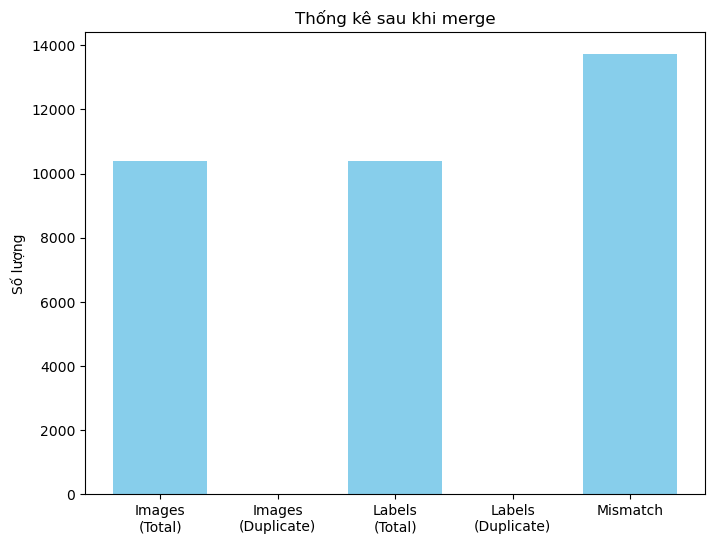

In [21]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import logging

# ------------------------------
# CẤU HÌNH LOGGING
# ------------------------------
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# ------------------------------
# CÁC MAPPING CHO DATASET
# ------------------------------
student_mapping = {
    0: 'drinking',
    1: 'raising_hand',
    2: 'sleeping',
    3: 'using_computer',
    4: 'using_phone',
    5: 'writing'
}

scb_mapping = {
    0: 'hand-raising',  # sẽ map sang 'raising_hand'
    1: 'read',          # nếu cần chuyển thành 'reading' thì thêm xử lý
    2: 'write'          # sẽ map sang 'writing'
}

# Unified mapping: sử dụng định nghĩa của Student, bổ sung lớp 'read'
unified_mapping = {
    'drinking': 0,
    'raising_hand': 1,
    'sleeping': 2,
    'using_computer': 3,
    'using_phone': 4,
    'writing': 5,
    'read': 6
}

# ------------------------------
# HÀM XỬ LÝ ANNOTATION SCB
# ------------------------------
def update_scb_annotation_line(line):
    """
    Chuyển đổi một dòng annotation của SCB sang unified mapping.
    Dòng annotation có định dạng: "cls x_center y_center width height"
    """
    parts = line.strip().split()
    if len(parts) < 5:
        return line  # nếu dòng không hợp lệ
    orig_cls = int(parts[0])
    
    # Lấy tên nhãn theo SCB
    class_name = scb_mapping.get(orig_cls)
    if class_name is None:
        return line
    
    # Map tên nhãn:
    # hand-raising -> raising_hand, write -> writing (read giữ nguyên)
    if class_name == 'hand-raising':
        class_name = 'raising_hand'
    elif class_name == 'write':
        class_name = 'writing'
    
    new_cls = unified_mapping.get(class_name)
    parts[0] = str(new_cls)
    return " ".join(parts)

def process_scb_annotations(scb_labels_dir, output_labels_dir):
    """
    Chuyển đổi toàn bộ file annotation của SCB từ scb_labels_dir sang output_labels_dir.
    """
    if not os.path.exists(output_labels_dir):
        os.makedirs(output_labels_dir)
    for filename in os.listdir(scb_labels_dir):
        if not filename.endswith(".txt"):
            continue
        input_path = os.path.join(scb_labels_dir, filename)
        output_path = os.path.join(output_labels_dir, filename)
        try:
            with open(input_path, 'r') as f:
                lines = f.readlines()
            updated_lines = [update_scb_annotation_line(line) for line in lines]
            with open(output_path, 'w') as f:
                f.write("\n".join(updated_lines))
            logging.info(f"Processed SCB annotation: {filename}")
        except Exception as e:
            logging.error(f"Lỗi xử lý file {filename}: {e}")

# ------------------------------
# HÀM COPY FILE AN TOÀN (SAFE COPY) VỚI XỬ LÝ TRÙNG TÊN
# ------------------------------
def safe_copy(src_path, dest_dir, prefix=""):
    """
    Copy file từ src_path sang dest_dir.
    Nếu file đã tồn tại, tự động đổi tên để tránh ghi đè (thêm prefix + _dup).
    Trả về tên file đích.
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    filename = os.path.basename(src_path)
    dest_path = os.path.join(dest_dir, prefix + filename)
    base, ext = os.path.splitext(prefix + filename)
    counter = 1
    # Nếu file tồn tại, thêm hậu tố _dup{counter}
    while os.path.exists(dest_path):
        dest_path = os.path.join(dest_dir, f"{base}_dup{counter}{ext}")
        counter += 1
    try:
        shutil.copy(src_path, dest_path)
        return os.path.basename(dest_path)
    except Exception as e:
        logging.error(f"Lỗi copy file {src_path} -> {dest_path}: {e}")
        return None

# ------------------------------
# HÀM THỐNG KÊ TỪ FOLDER
# ------------------------------
def get_files_stats(directory, valid_extensions):
    """
    Lấy danh sách file (chỉ tên file) từ directory có đuôi trong valid_extensions.
    """
    files = [f for f in os.listdir(directory) 
             if os.path.splitext(f)[1].lower() in valid_extensions]
    total = len(files)
    # Trong 1 folder, tên file thường đã duy nhất, nhưng nếu hợp nhất từ nhiều nguồn thì có thể trùng
    freq = {}
    duplicates = []
    for f in files:
        freq[f] = freq.get(f, 0) + 1
        if freq[f] > 1 and f not in duplicates:
            duplicates.append(f)
    return {"total": total, "files": files, "duplicates": duplicates}

def check_match(images_dir, labels_dir, image_exts, label_ext=".txt"):
    # Lấy danh sách tên file (không bao gồm phần mở rộng)
    image_files = [os.path.splitext(f)[0] for f in os.listdir(images_dir) 
                   if os.path.splitext(f)[1].lower() in image_exts]
    label_files = [os.path.splitext(f)[0] for f in os.listdir(labels_dir) 
                   if f.endswith(label_ext)]
    images_set = set(image_files)
    labels_set = set(label_files)
    images_without_labels = list(images_set - labels_set)
    labels_without_images = list(labels_set - images_set)
    # Trả về dictionary thay vì tuple
    return {"images_without_labels": images_without_labels, 
            "labels_without_images": labels_without_images}


def visualize_stats(stats_dict, title):
    """
    Vẽ biểu đồ cột hiển thị thống kê:
      - Total files
      - Số file duplicate
      - Số file không có đối ứng (nếu có)
    stats_dict: {'Images': {...}, 'Labels': {...}, 'Mismatch': {...}}
    """
    labels = []
    values = []
    for key, stat in stats_dict.items():
        # Nếu key có chứa từ "Mismatch", xử lý như một dictionary mismatch
        if "Mismatch" in key:
            # Lấy danh sách file ảnh không có label và label không có ảnh từ dictionary mismatch
            mismatch_count = len(stat.get("images_without_labels", [])) + len(stat.get("labels_without_images", []))
            labels.append(key)  # Dùng key gốc cho mục Mismatch
            values.append(mismatch_count)
        else:
            # Đối với các mục khác, ta giả định stat có khóa "total" và "duplicates"
            labels.append(key + "\n(Total)")
            values.append(stat["total"])
            labels.append(key + "\n(Duplicate)")
            values.append(len(stat["duplicates"]))
            
    plt.figure(figsize=(8,6))
    plt.bar(labels, values, color='skyblue')
    plt.ylabel("Số lượng")
    plt.title(title)
    plt.show()

# ------------------------------
# ĐƯỜNG DẪN DATASET NGUỒN VÀ MERGED
# ------------------------------
# Dataset Student (đã có sẵn) - các split
student_train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/images"
student_train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/labels"
student_valid_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/images"
student_valid_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/labels"
student_test_images_dir  = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/images"
student_test_labels_dir  = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/labels"

# Dataset SCB ban đầu - các split
scb_train_labels_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/labels/train"
scb_train_images_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/images/train"
scb_valid_labels_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/labels/val"
scb_valid_images_dir = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/images/val"
scb_test_labels_dir  = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/labels/test"
scb_test_images_dir  = "/home/minhnv/Documents/ntt/AiIot/FinalPorject/CodingYOLOv12_Ver2/Dataset/SCB5-HandRise-Read-Write/images/test"

# Folder output cho dataset merged (Student đã merge SCB)
merged_dataset_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/merged_dataset_student_scb"
merged_images_dir = os.path.join(merged_dataset_dir, "images")
merged_labels_dir = os.path.join(merged_dataset_dir, "labels")

os.makedirs(merged_images_dir, exist_ok=True)
os.makedirs(merged_labels_dir, exist_ok=True)

# ------------------------------
# HÀM THỐNG KÊ TRƯỚC KHI MERGE (TỔNG HỢP TỪ CÁC SPLIT)
# ------------------------------
valid_img_exts = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

def aggregate_stats(dirs, valid_exts, file_type="Images"):
    """
    Thu thập thống kê từ danh sách các folder.
    Trả về 1 dict với tổng số file và danh sách các file (dùng để tính duplicates).
    """
    all_files = []
    for d in dirs:
        try:
            files = [f for f in os.listdir(d) if os.path.splitext(f)[1].lower() in valid_exts]
            all_files.extend(files)
        except Exception as e:
            logging.error(f"Lỗi đọc folder {d}: {e}")
    freq = {}
    duplicates = []
    for f in all_files:
        freq[f] = freq.get(f, 0) + 1
        if freq[f] > 1 and f not in duplicates:
            duplicates.append(f)
    return {"total": len(all_files), "files": all_files, "duplicates": duplicates}

# Các folder nguồn
student_img_dirs = [student_train_images_dir, student_valid_images_dir, student_test_images_dir]
student_lbl_dirs = [student_train_labels_dir, student_valid_labels_dir, student_test_labels_dir]
scb_img_dirs = [scb_train_images_dir, scb_valid_images_dir, scb_test_images_dir]
scb_lbl_dirs = [scb_train_labels_dir, scb_valid_labels_dir, scb_test_labels_dir]

# Aggregate stats trước merge
pre_merge_student_images = aggregate_stats(student_img_dirs, valid_img_exts, "Images")
pre_merge_student_labels = aggregate_stats(student_lbl_dirs, [".txt"], "Labels")
pre_merge_scb_images = aggregate_stats(scb_img_dirs, valid_img_exts, "Images")
pre_merge_scb_labels = aggregate_stats(scb_lbl_dirs, [".txt"], "Labels")

# Kiểm tra sự không khớp giữa ảnh và label cho mỗi nguồn
def get_mismatch_stats(images_dir, labels_dir):
    imgs_without_lbl, lbls_without_img = check_match(images_dir, labels_dir, valid_img_exts)
    return {"images_without_labels": imgs_without_lbl, "labels_without_images": lbls_without_img}

# Ví dụ: lấy mismatch cho Student train (có thể lặp lại cho từng split)
student_train_mismatch = get_mismatch_stats(student_train_images_dir, student_train_labels_dir)
scb_train_mismatch = get_mismatch_stats(scb_train_images_dir, scb_train_labels_dir)

# Visualize thống kê trước merge
pre_merge_stats = {
    "Student Images": pre_merge_student_images,
    "Student Labels": pre_merge_student_labels,
    "SCB Images": pre_merge_scb_images,
    "SCB Labels": pre_merge_scb_labels,
    "Mismatch (Student Train)": student_train_mismatch,
    "Mismatch (SCB Train)": scb_train_mismatch
}

visualize_stats(pre_merge_stats, "Thống kê trước khi merge")

# ------------------------------
# BƯỚC MERGE DỮ LIỆU
# ------------------------------

# (A) COPY ANNOTATION CỦA STUDENT (từ các split) sang merged
for folder in student_lbl_dirs:
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            safe_copy(os.path.join(folder, filename), merged_labels_dir, prefix="stu_")

# (B) PROCESS ANNOTATION CỦA SCB (từ các split) và copy sang merged
for folder in scb_lbl_dirs:
    process_scb_annotations(folder, merged_labels_dir)

# (C) COPY ẢNH CỦA STUDENT (từ các split) sang merged
for folder in student_img_dirs:
    for filename in os.listdir(folder):
        ext = os.path.splitext(filename)[1].lower()
        if ext in valid_img_exts:
            safe_copy(os.path.join(folder, filename), merged_images_dir, prefix="stu_")

# (D) COPY ẢNH CỦA SCB (từ các split) sang merged
for folder in scb_img_dirs:
    for filename in os.listdir(folder):
        ext = os.path.splitext(filename)[1].lower()
        if ext in valid_img_exts:
            safe_copy(os.path.join(folder, filename), merged_images_dir, prefix="scb_")

logging.info("Merge dataset thành công!")

# ------------------------------
# THỐNG KÊ SAU KHI MERGE
# ------------------------------
post_merge_images = get_files_stats(merged_images_dir, valid_img_exts)
post_merge_labels = get_files_stats(merged_labels_dir, [".txt"])
post_merge_mismatch = check_match(merged_images_dir, merged_labels_dir, valid_img_exts)

post_merge_stats = {
    "Images": post_merge_images,
    "Labels": post_merge_labels,
    "Mismatch": post_merge_mismatch
}

visualize_stats(post_merge_stats, "Thống kê sau khi merge")


### Tôi muốn đoạn code di chuyển data scb vào đường dẫn Student-Behavior-Recognition-6 ( Tương ứng với train, valid, test ). Và chuyển class_names = {0: 'hand-raising', 1: 'read', 2: 'write'}  thành 4 5 6 . Nhớ chuyển cả ảnh vào trong folder Student-Behavior-Recognition-6 ( Tương ứng với train, valid, test ).

#### Kiểm tra ảnh và label không khớp

In [6]:
import os
import glob

def check_image_label_match(images_dir, labels_dir):
    """
    Kiểm tra sự khớp nhau giữa ảnh và file label dựa theo tên file (không phần mở rộng).
    Trả về 2 tập hợp:
      - missing_labels: các ảnh không có file label tương ứng.
      - missing_images: các file label không có ảnh tương ứng.
    """
    # Lấy danh sách file ảnh (chấp nhận các định dạng ảnh khác nhau)
    image_files = glob.glob(os.path.join(images_dir, "*.*"))
    # Lấy danh sách file label với định dạng .txt
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    # Lấy tên file (không phần mở rộng)
    image_bases = {os.path.splitext(os.path.basename(f))[0] for f in image_files}
    label_bases = {os.path.splitext(os.path.basename(f))[0] for f in label_files}

    missing_labels = image_bases - label_bases
    missing_images = label_bases - image_bases

    return missing_labels, missing_images

def run_test_case():
    base_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6"
    splits = ["train", "valid", "test"]
    
    for split in splits:
        images_dir = os.path.join(base_dir, split, "images")
        labels_dir = os.path.join(base_dir, split, "labels")
        
        missing_labels, missing_images = check_image_label_match(images_dir, labels_dir)
        
        print(f"\nKiểm tra tập {split}:")
        if missing_labels or missing_images:
            if missing_labels:
                print(" - Ảnh không có file label tương ứng:", missing_labels)
            if missing_images:
                print(" - File label không có ảnh tương ứng:", missing_images)
        else:
            print(" - Tất cả ảnh và label đều khớp nhau.")
            
if __name__ == '__main__':
    run_test_case()



Kiểm tra tập train:
 - Tất cả ảnh và label đều khớp nhau.

Kiểm tra tập valid:
 - Tất cả ảnh và label đều khớp nhau.

Kiểm tra tập test:
 - Tất cả ảnh và label đều khớp nhau.


### Thực hiện merge data

In [7]:
import os
import glob
import shutil

# ===== Đường dẫn SCB (source) =====
# Train
src_train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/train"
src_train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/train"
# Valid
src_val_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/val"
src_val_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/val"
# Test
src_test_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/test"
src_test_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/test"

# ===== Đường dẫn đích (Student-Behavior-Recognition-6) =====
# Train
dest_train_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/images"
dest_train_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/labels"
# Valid
dest_val_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/images"
dest_val_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/labels"
# Test
dest_test_images_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/images"
dest_test_labels_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/labels"

# ===== Mapping chuyển đổi class label =====
# Ban đầu: {0: 'hand-raising', 1: 'read', 2: 'write'}
# Sau khi chuyển: 0 -> 4, 1 -> 5, 2 -> 6
class_mapping = {0: 4, 1: 5, 2: 6}

def update_label_file(src_label_file, dest_label_file, class_mapping):
    """
    Đọc file label từ đường dẫn src_label_file, cập nhật class_id theo mapping,
    và ghi file mới tại dest_label_file.
    """
    with open(src_label_file, 'r') as f:
        lines = f.readlines()
    
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        try:
            cls = int(parts[0])
        except ValueError:
            continue
        if cls in class_mapping:
            new_cls = class_mapping[cls]
            new_line = " ".join([str(new_cls)] + parts[1:]) + "\n"
            new_lines.append(new_line)
        else:
            # Nếu không thuộc mapping (trường hợp bất thường) thì giữ nguyên dòng
            new_lines.append(line)
    
    with open(dest_label_file, 'w') as f:
        f.writelines(new_lines)

def process_dataset(src_images_dir, src_labels_dir, dest_images_dir, dest_labels_dir, class_mapping):
    """
    Copy ảnh và file label từ thư mục source sang thư mục destination,
    đồng thời cập nhật file label theo mapping class.
    """
    # Tạo thư mục đích nếu chưa tồn tại
    os.makedirs(dest_images_dir, exist_ok=True)
    os.makedirs(dest_labels_dir, exist_ok=True)

    # --- Copy ảnh ---
    image_files = glob.glob(os.path.join(src_images_dir, "*.*"))
    for img_file in image_files:
        shutil.copy(img_file, dest_images_dir)
    print(f"Đã copy {len(image_files)} ảnh từ {src_images_dir} sang {dest_images_dir}")

    # --- Cập nhật và copy file label ---
    label_files = glob.glob(os.path.join(src_labels_dir, "*.txt"))
    for label_file in label_files:
        dest_label_file = os.path.join(dest_labels_dir, os.path.basename(label_file))
        update_label_file(label_file, dest_label_file, class_mapping)
    print(f"Đã xử lý {len(label_files)} file label từ {src_labels_dir} sang {dest_labels_dir}")

# --- Xử lý cho train, valid và test ---
process_dataset(src_train_images_dir, src_train_labels_dir, dest_train_images_dir, dest_train_labels_dir, class_mapping)
process_dataset(src_val_images_dir, src_val_labels_dir, dest_val_images_dir, dest_val_labels_dir, class_mapping)
process_dataset(src_test_images_dir, src_test_labels_dir, dest_test_images_dir, dest_test_labels_dir, class_mapping)

print("Đã di chuyển dữ liệu SCB sang Student-Behavior-Recognition-6 và cập nhật class label thành 4, 5, 6!")


Đã copy 4674 ảnh từ /hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/train sang /hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/images
Đã xử lý 4674 file label từ /hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/train sang /hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/train/labels
Đã copy 1588 ảnh từ /hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/val sang /hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/images
Đã xử lý 1588 file label từ /hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/labels/val sang /hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/valid/labels
Đã copy 602 ảnh từ /hdd2/minhnv/CodingYOLOv12/Dataset/SCB5-Handrise-Read-write-2024-9-17/images/test sang /hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6/test/images
Đã xử lý 602 file label từ /hdd2/minhnv/CodingYOLOv12/Da

In [8]:
import os
import glob

def check_image_label_match(images_dir, labels_dir):
    """
    Kiểm tra sự khớp nhau giữa ảnh và file label dựa theo tên file (không phần mở rộng).
    Trả về 2 tập hợp:
      - missing_labels: các ảnh không có file label tương ứng.
      - missing_images: các file label không có ảnh tương ứng.
    """
    # Lấy danh sách file ảnh (chấp nhận các định dạng ảnh khác nhau)
    image_files = glob.glob(os.path.join(images_dir, "*.*"))
    # Lấy danh sách file label với định dạng .txt
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    # Lấy tên file (không phần mở rộng)
    image_bases = {os.path.splitext(os.path.basename(f))[0] for f in image_files}
    label_bases = {os.path.splitext(os.path.basename(f))[0] for f in label_files}

    missing_labels = image_bases - label_bases
    missing_images = label_bases - image_bases

    return missing_labels, missing_images

def run_test_case():
    base_dir = "/hdd2/minhnv/CodingYOLOv12/Dataset/Student-Behavior-Recognition-6"
    splits = ["train", "valid", "test"]
    
    for split in splits:
        images_dir = os.path.join(base_dir, split, "images")
        labels_dir = os.path.join(base_dir, split, "labels")
        
        missing_labels, missing_images = check_image_label_match(images_dir, labels_dir)
        
        print(f"\nKiểm tra tập {split}:")
        if missing_labels or missing_images:
            if missing_labels:
                print(" - Ảnh không có file label tương ứng:", missing_labels)
            if missing_images:
                print(" - File label không có ảnh tương ứng:", missing_images)
        else:
            print(" - Tất cả ảnh và label đều khớp nhau.")
            
if __name__ == '__main__':
    run_test_case()



Kiểm tra tập train:
 - Tất cả ảnh và label đều khớp nhau.

Kiểm tra tập valid:
 - Tất cả ảnh và label đều khớp nhau.

Kiểm tra tập test:
 - Tất cả ảnh và label đều khớp nhau.
